# Video Classification with Transformers

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


## Data collection

In [ ]:
!wget -q https://github.com/sayakpaul/Action-Recognition-in-TensorFlow/releases/download/v1.0.0/ucf101_top5.tar.gz
!tar -xf ucf101_top5.tar.gz

## Setup

In [ ]:
import os
import keras
from keras import layers
from keras.applications.densenet import DenseNet121

from tensorflow_docs.vis import embed

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2

## Define hyperparameters

In [ ]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 128

EPOCHS = 5

## Data preparation


In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)


def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = keras.ops.convert_to_numpy(cropped)
    cropped = keras.ops.squeeze(cropped)
    return cropped


# Following method is modified from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def load_video(path, max_frames=0, offload_to_cpu=False):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = frame[:, :, [2, 1, 0]]
            frame = crop_center(frame)
            if offload_to_cpu and keras.backend.backend() == "torch":
                frame = frame.to("cpu")
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    if offload_to_cpu and keras.backend.backend() == "torch":
        return np.array([frame.to("cpu").numpy() for frame in frames])
    return np.array(frames)


def build_feature_extractor():
    feature_extractor = DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


# Label preprocessing with StringLookup.
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())


def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels


Total videos for training: 594
Total videos for testing: 224
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


In [ ]:
!!wget -q https://git.io/JZmf4 -O top5_data_prepared.tar.gz
!!tar -xf top5_data_prepared.tar.gz

[]

In [ ]:
train_data, train_labels = np.load("train_data.npy"), np.load("train_labels.npy")
test_data, test_labels = np.load("test_data.npy"), np.load("test_labels.npy")

print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (594, 20, 1024)


## Building the Transformer-based model

In [ ]:

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def build(self, input_shape):
        self.position_embeddings.build(input_shape)

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        inputs = keras.ops.cast(inputs, self.compute_dtype)
        length = keras.ops.shape(inputs)[1]
        positions = keras.ops.arange(start=0, stop=length, step=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions


#LoRA

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, lora_r=4, lora_alpha=32, lora_dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation=keras.activations.gelu),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

        # LoRA-specific parameters
        self.lora_r = lora_r
        self.lora_alpha = lora_alpha
        self.lora_dropout = layers.Dropout(lora_dropout)

        # LoRA weight placeholders (will be initialized in build)
        self.lora_a = None
        self.lora_b = None
        self.scaling = self.lora_alpha / self.lora_r

    def build(self, input_shape):
        # Initialize LoRA weights
        self.lora_a = self.add_weight(
            shape=(self.embed_dim, self.lora_r),
            initializer="random_normal",
            trainable=True,
            name="lora_a",
        )
        self.lora_b = self.add_weight(
            shape=(self.lora_r, self.embed_dim),
            initializer="random_normal",
            trainable=True,
            name="lora_b",
        )

    def call(self, inputs, mask=None):
        # Standard attention output
        attention_output = self.attention(inputs, inputs, attention_mask=mask)

        # LoRA adaptation using tf.linalg.matmul
        lora_output = self.lora_dropout(
            tf.linalg.matmul(tf.linalg.matmul(inputs, self.lora_a), self.lora_b)
        ) * self.scaling

        # Add LoRA output to the attention output
        attention_output += lora_output

        # Projected output
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def compute_output_shape(self, input_shape):
        return input_shape  # Output shape matches input shape


## Utility functions for training

In [ ]:

def get_compiled_model(shape):
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=shape)
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


def run_experiment():
    filepath = "/tmp/video_classifier.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model(train_data.shape[1:])
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model


## Model training and inference

In [ ]:
trained_model = run_experiment()

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.4910 - loss: 2.0479
Epoch 1: val_loss improved from inf to 6.21150, saving model to /tmp/video_classifier.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 446ms/step - accuracy: 0.5013 - loss: 1.9989 - val_accuracy: 0.0000e+00 - val_loss: 6.2115
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9293 - loss: 0.3886
Epoch 2: val_loss improved from 6.21150 to 1.03721, saving model to /tmp/video_classifier.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9313 - loss: 0.3763 - val_accuracy: 0.5222 - val_loss: 1.0372
Epoch 3/5
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9827 - loss: 0.0477
Epoch 3: val_loss improved from 1.03721 to 0.38031, saving model to /tmp/video_classifier.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9847 - loss: 0.0428 - val_accuracy: 0.8556 - val_loss: 0.3803
Epoch 4/5
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9956 - loss: 0.0104
Epoch 4: val

In [ ]:
trained_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 20, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ frame_position_embedding             │ (None, 20, 1024)            │          20,480 │
│ (PositionalEmbedding)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_layer                    │ (None, 20, 1024)            │       4,219,908 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 1024)                │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,736,541 (48.59 MB)

 Trainable params: 4,245,513 (16.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,491,028 (32.39 MB)

Test video path: v_PlayingCello_g04_c03.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step
  PlayingCello: 100.00%
  Punch:  0.00%
  ShavingBeard:  0.00%
  TennisSwing:  0.00%
  CricketShot:  0.00%


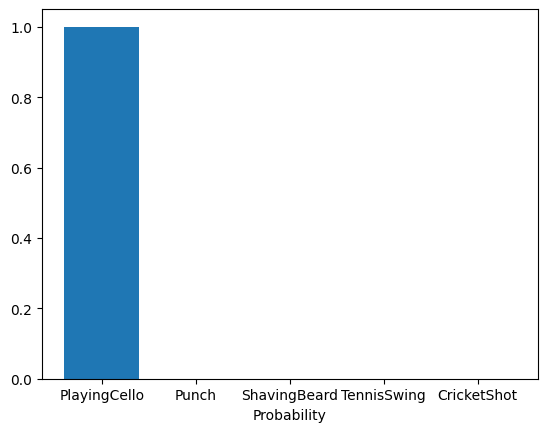


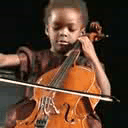

In [ ]:

def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path), offload_to_cpu=True)
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    plot_x_axis, plot_y_axis = [], []

    for i in np.argsort(probabilities)[::-1]:
        plot_x_axis.append(class_vocab[i])
        plot_y_axis.append(probabilities[i])
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

    plt.bar(plot_x_axis, plot_y_axis, label=plot_x_axis)
    plt.xlabel("class_label")
    plt.xlabel("Probability")
    plt.show()

    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [ ]:
import os
from IPython.display import Video

# Define the path to the .avi video file
avi_video_path = '/content/test/v_PlayingCello_g04_c03.avi'
mp4_video_path = '/content/v_PlayingCello_g04_c03.mp4'

# Check if the video file exists
if os.path.exists(avi_video_path):
    # Convert .avi to .mp4 using ffmpeg for compatibility
    !ffmpeg -y -loglevel panic -i {avi_video_path} {mp4_video_path}

    # Display the converted video
    if os.path.exists(mp4_video_path):
        display(Video(mp4_video_path, embed=True, width=960, height=540))
    else:
        print("Error: MP4 conversion failed.")
else:
    print(f"Error: AVI file not found at {avi_video_path}")
